In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

Using TensorFlow backend.


In [6]:

#Define target isoform loss function
def get_isoform_loss(target_isos, isoform_start=80, isoform_end=115, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, similarity_weight=0.0, similarity_margin=0.5, punish_dn_cse=0.0, punish_up_c=0.0, punish_dn_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_iso = np.zeros((len(target_isos), 1))
    for i, t_iso in enumerate(target_isos) :
        target_iso[i, 0] = t_iso
    
    masked_use_entropy_mse = get_target_entropy_sme_masked(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    masked_dse_entropy_mse = get_target_entropy_sme_masked(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=dse_end)
    
    punish_up_c_func = get_punish_c(pwm_start=use_start, pwm_end=use_end)
    punish_dn_c_func = get_punish_c(pwm_start=dse_start, pwm_end=dse_end)
    
    punish_up_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    punish_dn_g_func = get_punish_g(pwm_start=use_start, pwm_end=use_end)
    
    punish_up_aa_func = get_punish_aa(pwm_start=use_start, pwm_end=use_end)
    punish_dn_aa_func = get_punish_aa(pwm_start=dse_start, pwm_end=dse_end)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=70-60, pwm_end=76+60, margin=similarity_margin, shift_1_nt=True)
    
    extra_sim = np.ones((len(target_isos), 1, 205, 4, 1))
    for i in range(len(target_isos)) :
        extra_sim[i, 0, 70-4:76, :, 0] = 0.0
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Specify costs
        iso_loss = 2.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=1)
        
        seq_loss = 0.0
        seq_loss += punish_dn_cse * K.mean(punish_dn_cse_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_c * K.mean(punish_dn_c_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm_1), axis=1)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm_1), axis=1)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm_1), axis=1)
        
        
        extra_sims = K.constant(extra_sim)
        extra_sim_mask = K.gather(extra_sims, sequence_class[:, 0])
        extra_sim_mask = K.tile(extra_sim_mask, (1, K.shape(sampled_pwm_1)[1], 1, 1, 1))
        
        entropy_loss = entropy_weight * (masked_use_entropy_mse(pwm_1, mask) + cse_entropy_mse(pwm_1) + masked_dse_entropy_mse(pwm_1, mask))
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask * extra_sim_mask), axis=1)
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, library_contexts, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, pwm_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=1, eval_mode='pwm')
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    for layer in pwm_predictor.layers :
        if 'aparent' in layer.name :
            layer.name += "_pwmversion"
    
    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, pwm_loss_model = build_loss_model(pwm_predictor, loss_func)
    _, sample_loss_model = build_loss_model(sample_predictor, loss_func)
    
    dual_loss_out = Lambda(lambda x: 0.5 * x[0] + 0.5 * x[1])([pwm_loss_model.outputs[0], sample_loss_model.outputs[0]])

    loss_model = Model(inputs=pwm_loss_model.inputs, outputs=dual_loss_out)
    
    #Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch
    )

    return generator, sample_predictor, train_history


In [7]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

In [8]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple',
    'simple',
    'simple',
    'simple',
    'simple'
]

target_isos = [
    0.05,
    0.25,
    0.5,
    0.75,
    1.0
]

margin_similarities = [
    0.3,
    0.3,
    0.3,
    0.3,
    0.5
]


In [ ]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS")

#Number of PWMs to generate per objective
batch_size = 36
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 50
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

for class_i in range(len(sequence_templates)) :
    print("Target iso = " + str(target_isos[class_i]))
    
    lib_name = library_contexts[class_i].split("_")[0]
    print("Library context = " + str(lib_name))
    
    K.clear_session()
    
    loss = get_isoform_loss(
        [target_isos[class_i]],
        use_start=22,
        use_end=70,
        use_target_bits=1.95,
        cse_start=70,
        cse_end=76,
        cse_target_bits=1.95,
        dse_start=76,
        dse_end=121,
        dse_target_bits=1.95,
        entropy_weight=1.0,
        similarity_weight=5.0,
        similarity_margin=margin_similarities[class_i],
        punish_dn_cse=1.0,
        punish_up_c=0.0015,
        punish_dn_c=0.0001,
        punish_up_g=0.0001,
        punish_dn_g=0.0001,
        punish_up_aa=0.00025,
        punish_dn_aa=0.005
    )

    genesis_generator, genesis_predictor, train_history = run_genesis([sequence_templates[class_i]], loss, [library_contexts[class_i]], saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch)

    genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
    genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
    genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

    genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
    genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
    genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

    # Save model and weights
    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    model_name = 'genesis_target_isoform_' + str(target_isos[class_i]).replace(".", "") + '_pwm_and_multisample_marginsimilarity_hardersimilarity_' + str(lib_name) + '_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_' + str(margin_similarities[class_i]).replace(".", "") + '_generator.h5'
    model_path = os.path.join(save_dir, model_name)
    genesis_generator.save(model_path)
    print('Saved trained model at %s ' % model_path)

    model_name = 'genesis_target_isoform_' + str(target_isos[class_i]).replace(".", "") + '_pwm_and_multisample_marginsimilarity_hardersimilarity_' + str(lib_name) + '_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_' + str(margin_similarities[class_i]).replace(".", "") + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)
    genesis_predictor.save(model_path)
    print('Saved trained model at %s ' % model_path)
    

In [2]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), 'saved_models')
saved_predictor_model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)

Target iso = 1.0


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


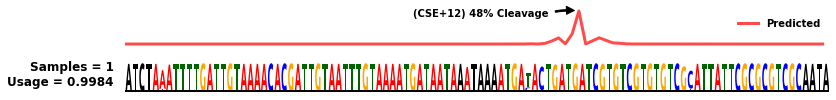

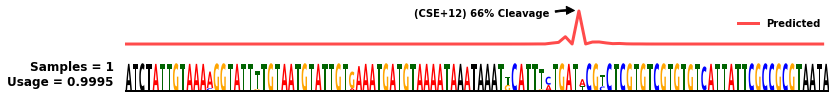

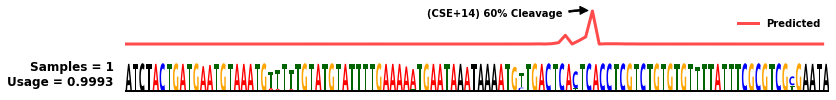

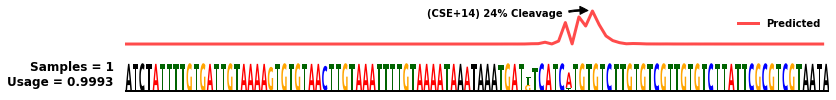

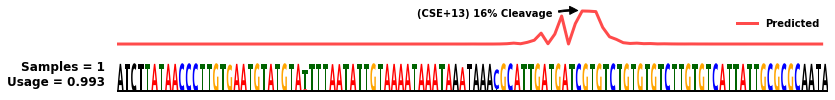

Target iso = 0.75


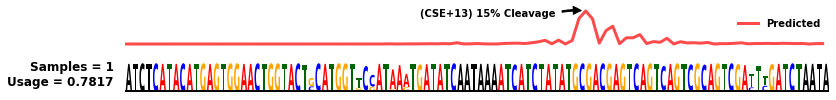

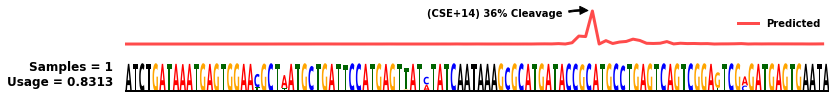

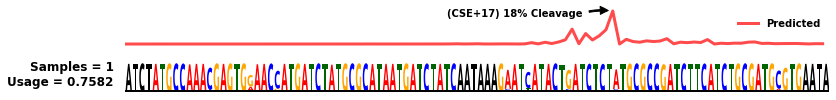

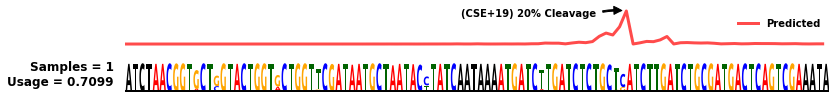

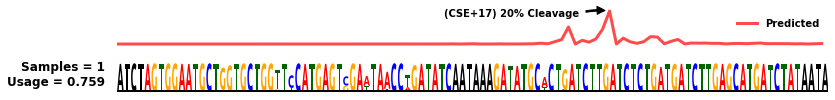

Target iso = 0.5


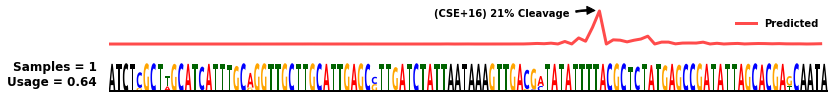

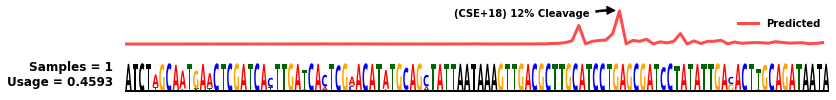

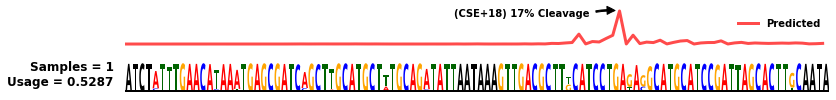

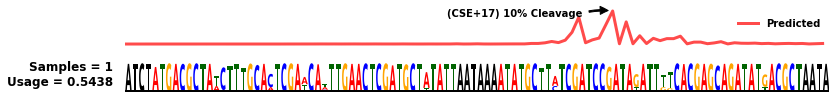

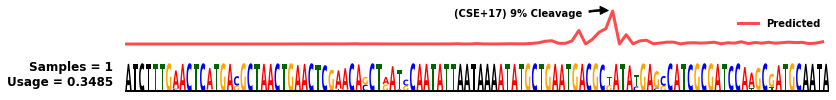

Target iso = 0.25


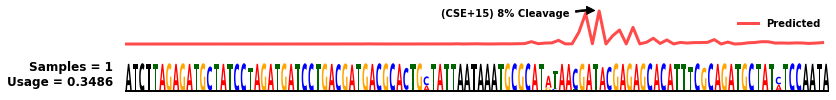

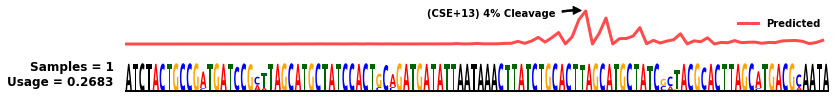

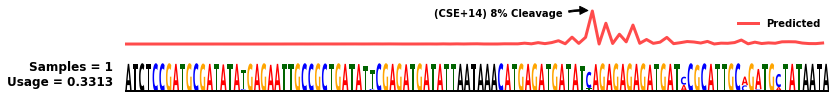

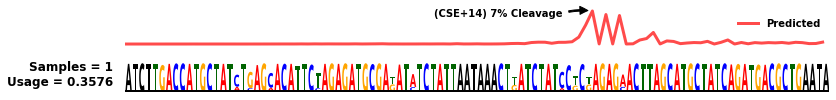

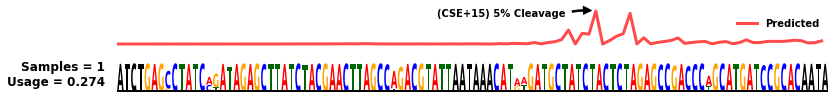

Target iso = 0.05


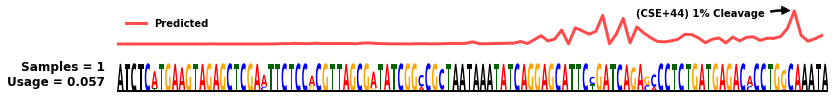

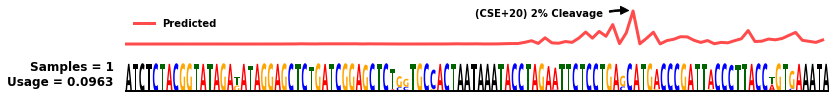

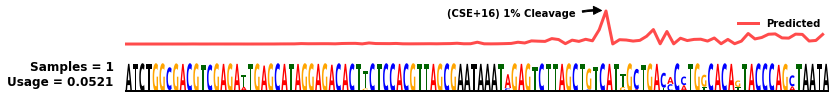

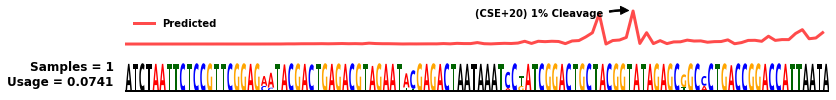

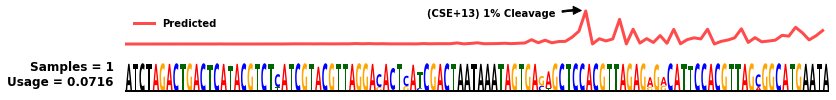

In [4]:
#Load GENESIS models and predict sample sequences

model_names = [
    'genesis_target_isoform_005_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_025_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_05_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_075_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1',
]

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple',
    'simple',
    'simple',
    'simple',
    'simple'
]

target_isos = [
    0.05,
    0.25,
    0.5,
    0.75,
    1.0
]


for class_i in range(len(sequence_templates)-1, 0-1, -1) :
    print("Target iso = " + str(target_isos[class_i]))
    
    save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
    model_name = model_names[class_i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    n = 36

    sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)

    _, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs
    
    #Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

    for pwm_index in range(5) :

        sequence_template = sequence_templates[class_i]

        pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
        cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
        iso = np.expand_dims(np.sum(cut[:, 80: 115], axis=-1), axis=-1)

        plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-49, plot_end=76+49, save_figs=False, fig_name='target_isoform_genesis_simple_' + str(target_isos[class_i]).replace(".", "") + "_pwm_index_" + str(pwm_index), fig_dpi=150)


Target iso = 1.0


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


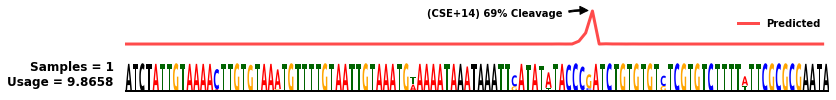

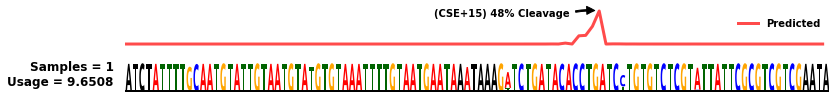

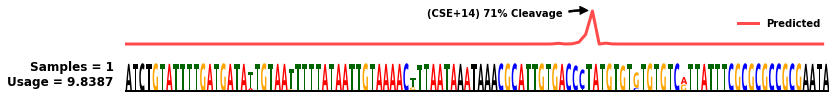

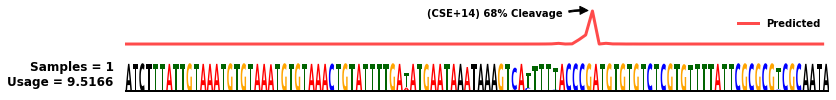

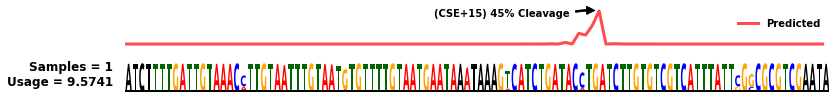

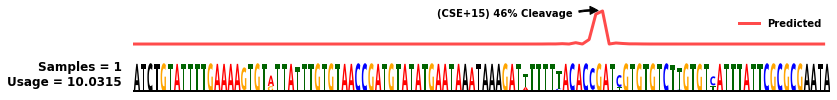

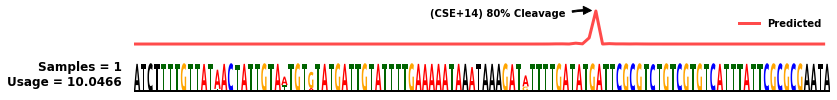

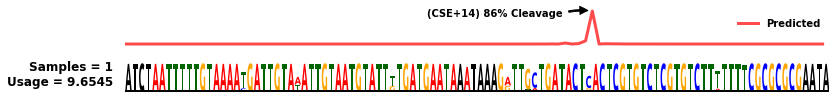

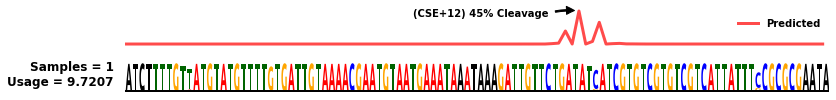

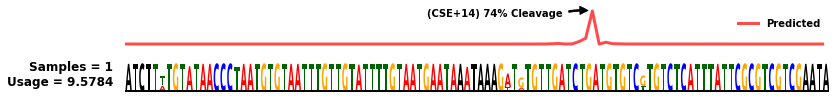

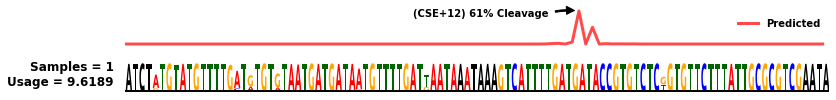

In [7]:
#Enrich for near-optimal sampled PAS sequences

model_names = [
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1',
]

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple'
]

target_isos = [
    1.0
]


for class_i in range(len(sequence_templates)-1, 0-1, -1) :
    print("Target iso = " + str(target_isos[class_i]))
    
    save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
    model_name = model_names[class_i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    n = 10000
    n_ceil = int(n / 36) * 36 + 36

    sequence_class = np.array([0] * n_ceil).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

    noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
    noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)

    _, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs
    
    #Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

    n_chosen = 0
    for pwm_index in range(n) :

        sequence_template = sequence_templates[class_i]

        pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
        cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
        iso = np.expand_dims(np.sum(cut[:, 80: 115], axis=-1), axis=-1)
        
        logodds = np.log(iso[0, 0] / (1. - iso[0, 0]))
        if logodds >= 9.5 :
            n_chosen += 1

            plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=70-49, plot_end=76+49, save_figs=False, fig_name='max_isoform_genesis_simple_' + str(target_isos[class_i]).replace(".", "") + "_pwm_index_" + str(pwm_index), fig_dpi=150)
        
        if n_chosen > 10 :
            break


In [4]:

model_names = [
    'genesis_target_isoform_005_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_025_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_05_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_075_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1',
]

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple',
    'simple',
    'simple',
    'simple',
    'simple'
]

target_isos = [
    0.05,
    0.25,
    0.5,
    0.75,
    1.0
]

n_classes = 5

isoform_start = 80
isoform_end = 115


Predicting sequences for objective 0...
N Sequences = 10


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


36/36 [==============================] - 2s 49ms/step
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


108/108 [==============================] - 3s 24ms/step
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1008/1008 [==============================] - 12s 12ms/step
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


10008/10008 [==============================] - 119s 12ms/step
Number of unique sequences = 10000
Duplication rate = 0.0
N Sequences = 100000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


100008/100008 [==============================] - 1124s 11ms/step
Number of unique sequences = 100000
Duplication rate = 0.0
Predicting sequences for objective 1...
N Sequences = 10


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


36/36 [==============================] - 2s 63ms/step
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


108/108 [==============================] - 3s 28ms/step
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1008/1008 [==============================] - 12s 12ms/step
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


10008/10008 [==============================] - 113s 11ms/step
Number of unique sequences = 10000
Duplication rate = 0.0
N Sequences = 100000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


100008/100008 [==============================] - 1109s 11ms/step
Number of unique sequences = 100000
Duplication rate = 0.0
Predicting sequences for objective 2...
N Sequences = 10


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


36/36 [==============================] - 3s 79ms/step
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


108/108 [==============================] - 4s 33ms/step
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1008/1008 [==============================] - 13s 12ms/step
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


10008/10008 [==============================] - 112s 11ms/step
Number of unique sequences = 10000
Duplication rate = 0.0
N Sequences = 100000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


100008/100008 [==============================] - 1171s 12ms/step
Number of unique sequences = 100000
Duplication rate = 0.0
Predicting sequences for objective 3...
N Sequences = 10


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


36/36 [==============================] - 3s 94ms/step
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


108/108 [==============================] - 4s 39ms/step
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1008/1008 [==============================] - 14s 14ms/step
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


10008/10008 [==============================] - 123s 12ms/step
Number of unique sequences = 10000
Duplication rate = 0.0
N Sequences = 100000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


100008/100008 [==============================] - 1176s 12ms/step
Number of unique sequences = 100000
Duplication rate = 0.0
Predicting sequences for objective 4...
N Sequences = 10


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


36/36 [==============================] - 6s 158ms/step
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


108/108 [==============================] - 5s 50ms/step
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1008/1008 [==============================] - 16s 16ms/step
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


10008/10008 [==============================] - 121s 12ms/step
Number of unique sequences = 10000
Duplication rate = 0.0
N Sequences = 100000


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


100008/100008 [==============================] - 1192s 12ms/step
Number of unique sequences = 100000
Duplication rate = 0.0


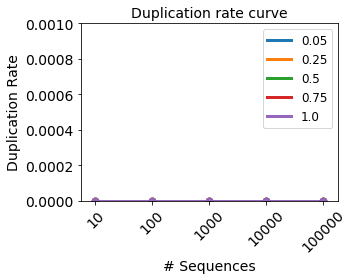

In [8]:

#Estimate duplication rates

def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

f = plt.figure(figsize=(5, 4))

n_sequences_large_list = [10, 100, 1000, 10000, 100000]

ls = []

save_figs = False

for k in range(n_classes) :
    print('Predicting sequences for objective ' + str(k) + '...')
    
    dup_rates = []
    
    for n_sequences_large in n_sequences_large_list :
        n_sequences_ceil_large = int(n_sequences_large / 36) * 36 + 36

        print("N Sequences = " + str(n_sequences_large))

        save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
        model_name = model_names[k] + '_predictor.h5'
        model_path = os.path.join(save_dir, model_name)

        predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
        
        sequence_class = np.tile(np.array([[0]]), (n_sequences_ceil_large, 1))

        noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))
        noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))

        pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36, verbose=True)

        _, _, _, optimized_pwm_large, _, sampled_pwm_large, _, _, _, _, _, _, _ = pred_outputs

        onehots_large = sampled_pwm_large[:, 0, :, :, :]


        consensus_seqs_large = []

        for i in range(onehots_large.shape[0]) :
            consensus_seqs_large.append(get_consensus_sequence(onehots_large[i, :, :, 0]))

        consensus_seqs_large = np.array(consensus_seqs_large, dtype=np.object)

        #Sample first n_sequences
        onehots_large_kept = onehots_large[:n_sequences_large, :, :]
        consensus_large_seqs_kept = consensus_seqs_large[:n_sequences_large]

        n_unique_seqs_kept = len(np.unique(consensus_large_seqs_kept))

        print("Number of unique sequences = " + str(n_unique_seqs_kept))

        dup_rate = 1. - n_unique_seqs_kept / n_sequences_large
        dup_rates.append(dup_rate)

        print("Duplication rate = " + str(round(dup_rate, 4)))


    l1 = plt.plot(np.arange(len(n_sequences_large_list)), dup_rates, linewidth=3, linestyle='-', label="" + str(target_isos[k]))
    plt.scatter(np.arange(len(n_sequences_large_list)), dup_rates, s=45)
    
    ls.append(l1[0])

plt.xlabel("# Sequences", fontsize=14)
plt.ylabel("Duplication Rate", fontsize=14)
plt.xticks(np.arange(len(n_sequences_large_list)), n_sequences_large_list, fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylim(0, np.max(dup_rates) * 1.10 + 0.001)

plt.title("Duplication rate curve", fontsize=14)

plt.legend(handles=ls, fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("apa_isoform_simple_dup_rate_curve.eps")
    plt.savefig("apa_isoform_simple_dup_rate_curve.svg")
    plt.savefig("apa_isoform_simple_dup_rate_curve.png", transparent=True, dpi=150)

plt.show()


In [10]:
#Helper function to get the conensus sequence from a PWM
def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus


n_sequences = 1000
n_sequences_ceil = int(n_sequences / 36) * 36 + 36

pwms = []
consensus_seqs = []
onehot_seqs = []
iso_preds = []
cut_preds = []
objectives = []

onehot_encoder = isol.OneHotEncoder(205)

for k in range(n_classes) :
    print('Predicting sequences for objective ' + str(k) + '...')
    
    save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
    model_name = model_names[k] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    
    
    sequence_class = np.tile(np.array([[0]]), (n_sequences_ceil, 1))
    
    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil, 100))
    
    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)
    _, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs

    optimized_pwm = np.expand_dims(optimized_pwm[:n_sequences, :, :, 0], axis=0)
    iso_pred = iso_pred[:n_sequences, 0, 0]
    cut_pred = cut_pred[:n_sequences, 0, :]
    
    #iso_pred = np.expand_dims(np.sum(cut_pred[:, obj_ix-1:obj_ix+2], axis=-1), axis=0)
    iso_pred = np.expand_dims(iso_pred, axis=0)
    cut_pred = np.expand_dims(cut_pred, axis=0)
    
    pwms.append(optimized_pwm)
    iso_preds.append(iso_pred)
    cut_preds.append(cut_pred)
    
    consensus_seqs.append([])
    onehot_seqs.append([])
    for i in range(n_sequences) :
        consensus_seqs[k].append(get_consensus_sequence(optimized_pwm[0, i, :, :]))
        onehot_seqs[k].append(onehot_encoder(get_consensus_sequence(optimized_pwm[0, i, :, :])))
    
    consensus_seqs[k] = np.expand_dims(np.array(consensus_seqs[k], dtype=np.object), axis=0)
    onehot_seqs[k] = np.expand_dims(onehot_seqs[k], axis=0)
    
    objectives.append(np.zeros((1, n_sequences)) + k)

pwms = np.concatenate(pwms, axis=0)
iso_preds = np.concatenate(iso_preds, axis=0)
cut_preds = np.concatenate(cut_preds, axis=0)
consensus_seqs = np.concatenate(consensus_seqs, axis=0)
onehot_seqs = np.concatenate(onehot_seqs, axis=0)
objectives = np.concatenate(objectives, axis=0)

print('pwms.shape = ' + str(pwms.shape))
print('iso_preds.shape = ' + str(iso_preds.shape))
print('cut_preds.shape = ' + str(cut_preds.shape))
print('consensus_seqs.shape = ' + str(consensus_seqs.shape))
print('onehot_seqs.shape = ' + str(onehot_seqs.shape))
print('objectives.shape = ' + str(objectives.shape))

Predicting sequences for objective 0...


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting sequences for objective 1...


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting sequences for objective 2...


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting sequences for objective 3...


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting sequences for objective 4...


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


pwms.shape = (5, 1000, 205, 4)
iso_preds.shape = (5, 1000)
cut_preds.shape = (5, 1000, 206)
consensus_seqs.shape = (5, 1000)
onehot_seqs.shape = (5, 1000, 205, 4)
objectives.shape = (5, 1000)


In [12]:
import scipy
import scipy.sparse as sp

for k in range(n_classes) :
    print('Computing sequence diversity for objective ' + str(k) + '...')

    consensus_seqs_ent = consensus_seqs[k]

    consensus_seqs_ent = np.array(consensus_seqs_ent, dtype=np.object)

    #Sample first n_sequences
    onehots_kept = onehot_seqs[:n_sequences, :, :]
    consensus_seqs_kept = consensus_seqs_ent[:n_sequences]

    print("Number of unique sequences = " + str(len(np.unique(consensus_seqs_kept))))

    #Calculate average/std nucleotide entropy

    nt_entropies = []
    for j in range(onehots_kept.shape[2]) :
        if sequence_templates[0][j] == 'N' :

            p_A = np.sum(onehots_kept[:, j, 0, 0]) / n_sequences
            p_C = np.sum(onehots_kept[:, j, 1, 0]) / n_sequences
            p_G = np.sum(onehots_kept[:, j, 2, 0]) / n_sequences
            p_T = np.sum(onehots_kept[:, j, 3, 0]) / n_sequences

            nt_entropy = 0
            if p_A * p_C * p_G * p_T > 0. :
                nt_entropy = - (p_A * np.log2(p_A) + p_C * np.log2(p_C) + p_G * np.log2(p_G) + p_T * np.log2(p_T))

            nt_entropies.append(nt_entropy)

    nt_entropies = np.array(nt_entropies)

    print("Mean NT Entropy = " + str(round(np.mean(nt_entropies), 4)))
    print("Std NT Entropy = " + str(round(np.std(nt_entropies), 4)))


    #Calculate hexamer entropies

    hexamer_encoder = isol.NMerEncoder(n_mer_len=6, count_n_mers=True)

    hexamers = isol.SparseBatchEncoder(encoder=hexamer_encoder)([x[20:128] for x in consensus_seqs_kept])

    print(hexamers.shape)

    hexamer_sum = np.ravel(hexamers.sum(axis=0))

    hexamers_probs = hexamer_sum / np.sum(hexamer_sum)

    n_nonzero_hexamers = len(np.nonzero(hexamer_sum > 0)[0])

    print("Number of unique hexamers = " + str(n_nonzero_hexamers))


    hexamer_entropy = -1. * np.sum(hexamers_probs[hexamer_sum > 0] * np.log2(hexamers_probs[hexamer_sum > 0]))

    print("Hexamer Entropy = " + str(hexamer_entropy))


    #Calculate average/std hexamer entropy

    nonzero_index = np.nonzero(hexamer_sum > 0)[0]

    hexamer_entropies = []
    for j in range(n_nonzero_hexamers) :
        p_on = len(np.nonzero(hexamers[:, nonzero_index[j]] > 0)[0]) / hexamers.shape[0]
        p_off = 1. - p_on

        hexamer_entropy = 0
        if p_on * p_off > 0. :
            hexamer_entropy = -(p_on * np.log2(p_on) + p_off * np.log2(p_off))

        hexamer_entropies.append(hexamer_entropy)

    hexamer_entropies = np.array(hexamer_entropies)

    print("Mean Binary Hexamer Entropy = " + str(round(np.mean(hexamer_entropies), 4)))
    print("Std Binary Hexamer Entropy = " + str(round(np.std(hexamer_entropies), 4)))



Computing sequence diversity for objective 0...
Number of unique sequences = 1000
Mean NT Entropy = 0.0
Std NT Entropy = 0.0
(1000, 4096)
Number of unique hexamers = 3203
Hexamer Entropy = 10.000972555104145
Mean Binary Hexamer Entropy = 0.1452
Std Binary Hexamer Entropy = 0.1784
Computing sequence diversity for objective 1...
Number of unique sequences = 1000
Mean NT Entropy = 0.0
Std NT Entropy = 0.0
(1000, 4096)
Number of unique hexamers = 2147
Hexamer Entropy = 9.139800273429685
Mean Binary Hexamer Entropy = 0.1702
Std Binary Hexamer Entropy = 0.2263
Computing sequence diversity for objective 2...
Number of unique sequences = 1000
Mean NT Entropy = 0.0
Std NT Entropy = 0.0
(1000, 4096)
Number of unique hexamers = 2490
Hexamer Entropy = 9.533328463722718
Mean Binary Hexamer Entropy = 0.1648
Std Binary Hexamer Entropy = 0.216
Computing sequence diversity for objective 3...
Number of unique sequences = 1000
Mean NT Entropy = 0.0
Std NT Entropy = 0.0
(1000, 4096)
Number of unique hexam

n_unique_sequences = 1000
Mean Iso Prop (Obj 0) = 0.0525
Std Iso Prop (Obj 0) = 0.0242
Mean Iso Log Odds (Obj 0) = -2.987
Std Iso Log Odds (Obj 0) = 0.4582
-------------------------
Mean Iso Prop (Obj 1) = 0.2506
Std Iso Prop (Obj 1) = 0.0566
Mean Iso Log Odds (Obj 1) = -1.1178
Std Iso Log Odds (Obj 1) = 0.3024
-------------------------
Mean Iso Prop (Obj 2) = 0.5063
Std Iso Prop (Obj 2) = 0.0629
Mean Iso Log Odds (Obj 2) = 0.0255
Std Iso Log Odds (Obj 2) = 0.2555
-------------------------
Mean Iso Prop (Obj 3) = 0.742
Std Iso Prop (Obj 3) = 0.0579
Mean Iso Log Odds (Obj 3) = 1.0788
Std Iso Log Odds (Obj 3) = 0.3076
-------------------------
Mean Iso Prop (Obj 4) = 0.9998
Std Iso Prop (Obj 4) = 0.0002
Mean Iso Log Odds (Obj 4) = 8.6844
Std Iso Log Odds (Obj 4) = 0.7242
-------------------------


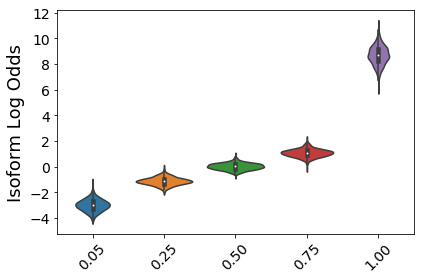

In [13]:

#Uniquely generated sequences per objective

unique_count = len(np.unique(consensus_seqs[0, :]))

print('n_unique_sequences = ' + str(unique_count))


#Target vs. Engineered Isoform Log Odds

save_figs = False

iso_props = [iso_preds[k, :] for k in range(n_classes)]
iso_logodds = [np.log(iso_preds[k, :] / (1.0 - iso_preds[k, :])) for k in range(n_classes)]

for k in range(n_classes) :
    print("Mean Iso Prop (Obj " + str(k) + ") = " + str(round(np.mean(iso_props[k]), 4)))
    print("Std Iso Prop (Obj " + str(k) + ") = " + str(round(np.std(iso_props[k]), 4)))
    print("Mean Iso Log Odds (Obj " + str(k) + ") = " + str(round(np.mean(iso_logodds[k]), 4)))
    print("Std Iso Log Odds (Obj " + str(k) + ") = " + str(round(np.std(iso_logodds[k]), 4)))
    print("-------------------------")
    

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=iso_logodds, axis=0)

plt.xticks(np.arange(5), ['0.05', '0.25', '0.50', '0.75', '1.00'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylabel('Isoform Log Odds', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig('target_isoform_genesis_simple_iso_magnitude.png', transparent=True, dpi=150)
    plt.savefig('target_isoform_genesis_simple_iso_magnitude.eps')
    plt.savefig('target_isoform_genesis_simple_iso_magnitude.svg')

plt.show()



In [10]:
#Load GENESIS models and predict sample sequences


model_names = [
    'genesis_target_isoform_005_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_025_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_05_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_075_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_03_retry_1',
    'genesis_target_isoform_10_pwm_and_multisample_marginsimilarity_hardersimilarity_simple_sym_kl_concat_lesserpunishupc_lesspunishaa_marginsim_05_retry_1',
]

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG',
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]

library_contexts = [
    'simple',
    'simple',
    'simple',
    'simple',
    'simple'
]

target_isos = [
    0.05,
    0.25,
    0.5,
    0.75,
    1.0
]

flat_pwms_collection = []

for class_i in range(len(sequence_templates)) :
    print("Target iso = " + str(target_isos[class_i]))
    
    save_dir = os.path.join(os.getcwd(), 'saved_models/target_isoform')
    model_name = model_names[class_i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    n = 36

    sequence_class = np.array(([0] * n)).reshape(-1, 1)

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=36)

    _, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs


    pwms = optimized_pwm[:, :, :, 0]

    flat_pwms = np.zeros((n, 205))
    for i in range(n) :
        for j in range(205) :
            max_nt_ix = np.argmax(pwms[i, j, :])

            flat_pwms[i, j] = max_nt_ix + 1


    flat_pwms = flat_pwms[:20, 70-45: 76+45]

    print(flat_pwms.shape)
    
    flat_pwms_collection.append(flat_pwms)


flat_pwms = np.concatenate(flat_pwms_collection[::-1], axis=0)

Target iso = 0.05


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 96)
Target iso = 0.25


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 96)
Target iso = 0.5


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 96)
Target iso = 0.75


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 96)
Target iso = 1.0


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(20, 96)


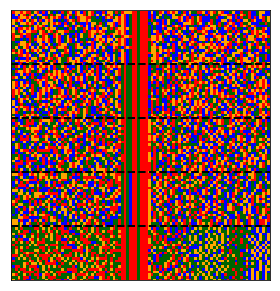

In [11]:
#Plot diversity grid

save_figs = False

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

f = plt.figure(figsize=(4, 12))

plt.imshow(flat_pwms[:100, :], aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

plt.plot([0, 96], [20, 20], linewidth=2, color='black', linestyle='--')
plt.plot([0, 96], [40, 40], linewidth=2, color='black', linestyle='--')
plt.plot([0, 96], [60, 60], linewidth=2, color='black', linestyle='--')
plt.plot([0, 96], [80, 80], linewidth=2, color='black', linestyle='--')

plt.xticks([], [])
plt.yticks([], [])

plt.xlim(0, 96)
plt.ylim(0, 100)

plt.tight_layout()

if save_figs :
    plt.savefig('genesis_apa_target_isoform_simple_image_seqs.png', transparent=True, dpi=150)
    plt.savefig('genesis_apa_target_isoform_simple_image_seqs.svg')
    plt.savefig('genesis_apa_target_isoform_simple_image_seqs.eps')

plt.show()